# Environment

In [28]:
import os
import sys
import csv
from io import BytesIO
import json
import base64
import pickle
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict

import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from upsetplot import from_memberships, UpSet
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
import pandas as pd
from collections import Counter
from itertools import combinations
import seaborn as sns


import ipywidgets as widgets
from IPython.display import display

import importlib

sys.path.insert(0, "/home/michal.kubacki/Githubs/GeneScore/project_functions")

import helpers_internal_data
importlib.reload(helpers_internal_data)
from helpers_internal_data import *

import load_gene_sets 
importlib.reload(load_gene_sets)
from load_gene_sets import *

import ploting_workbook 
importlib.reload(ploting_workbook)
from ploting_workbook import *

In [29]:
root_dir = "/group/testa/michal.kubacki/herring_minimal"
data_path = "/group/testa/michal.kubacki/herring_minimal/data"
output_path = "/home/michal.kubacki/Githubs/GeneScore/trimmed_Evaluation/output"
scplus_path = '/group/testa/michal.kubacki/herring_minimal/all_ex'

# Local Functions

In [30]:
def create_heatmap(data, set_selected, scored_genes, cell_types):
    gene_counts = {
        scored_gene: {
            cell_type: len(data[set_selected][cell_type][scored_gene]['targets'])
            for cell_type in cell_types
        }
        for scored_gene in scored_genes
    }
    df = pd.DataFrame(gene_counts)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, fmt='d', cmap='YlOrRd')
    plt.title("Number of Target Genes for Each Scored Gene Across Cell Types")
    plt.ylabel("Cell Types")
    plt.xlabel("Scored Genes")
    plt.tight_layout()
    plt.show()

def create_venn_diagram_gene_set(gene_sets, cell_type, mode="positive", printouts=False):
    set_names = list(gene_sets.keys())
    venn_sets = [set(genes) for genes in gene_sets.values()]
    
    if printouts:
        print(f"\nShared genes between the sets:")
        all_sets = set.union(*venn_sets)
        for i in range(2, len(venn_sets) + 1):
            for combination in itertools.combinations(range(len(venn_sets)), i):
                shared_genes = set.intersection(*(venn_sets[j] for j in combination))
                if shared_genes:
                    set_names_str = " & ".join(set_names[j] for j in combination)
                    print(f"Shared between {set_names_str}: {shared_genes}")

    if len(set_names) == 2:
        plt.figure(figsize=(10, 10))
        venn2(venn_sets, set_labels=set_names)
        plt.title(f"Genes Intersection for {cell_type}, coefficients: {mode}", fontsize=16)
        plt.show()
    elif len(set_names) == 3:
        plt.figure(figsize=(10, 10))
        venn3(venn_sets, set_labels=set_names)
        plt.title(f"Genes Intersection for {cell_type}, coefficients: {mode}", fontsize=16)
        plt.show()
    else:
        print(f"More than 3 sets detected for {cell_type}, coefficients: {mode}. Displaying text-based representation.")
        for i in range(2, min(len(set_names) + 1, 4)):
            for combo in combinations(range(len(set_names)), i):
                common_genes = set.intersection(*[venn_sets[j] for j in combo])
                if common_genes:
                    print(f"Genes common to {', '.join([set_names[j] for j in combo])}: {common_genes}")

def print_set_statistics_gene_set(gene_sets, cell_type):
    print(f"\nSet Statistics for {cell_type}:")
    for set_name, genes in gene_sets.items():
        print(f"  {set_name}: {len(genes)} genes")
    
    all_genes = set.union(*[set(genes) for genes in gene_sets.values()])
    print(f"  Total unique genes: {len(all_genes)}")
    
    intersection = set.intersection(*[set(genes) for genes in gene_sets.values()])
    print(f"  Genes present in all sets: {len(intersection)}")
    
    for i, set_name in enumerate(gene_sets.keys()):
        other_sets = [set(genes) for j, genes in enumerate(gene_sets.values()) if j != i]
        unique_genes = set(gene_sets[set_name]) - set.union(*other_sets)
        print(f"  Genes unique to {set_name}: {len(unique_genes)}")

def analyze_gene_sets_gene_set(data, set_selected, cell_type, scored_genes, mode="positive", printouts=False):
    gene_sets = {}
    for scored_gene in scored_genes:
        targets = data[set_selected][cell_type][scored_gene]['targets']
        coefs = data[set_selected][cell_type][scored_gene]['coef_mean']
        
        # Ensure targets and coefs are the same length
        if len(targets) != len(coefs):
            raise ValueError(f"Mismatch in length of targets and coefficients for {scored_gene}")
        
        # Filter targets based on coefficient signs
        if mode == "positive":
            filtered_targets = [target for target, coef in zip(targets, coefs) if coef > 0]
        else:
            filtered_targets = [target for target, coef in zip(targets, coefs) if coef < 0]
        
        # Only add to gene_sets if there are filtered targets
        if filtered_targets:
            gene_sets[scored_gene] = set(filtered_targets)
    
    create_venn_diagram_gene_set(gene_sets, cell_type, mode=mode, printouts=printouts)

def create_venn_diagram_cell_types(gene_sets, scored_gene, mode="positive", printouts=False):
    set_names = list(gene_sets.keys())
    venn_sets = [set(genes) for genes in gene_sets.values()]
    
    if printouts:
        print(f"\nUnique genes for each set:")
        for name, gene_set in zip(set_names, venn_sets):
            unique_genes = gene_set - set.union(*(s for s in venn_sets if s != gene_set))
            print(f"{name}: {unique_genes}")
    
    if len(set_names) == 2:
        plt.figure(figsize=(10, 10))
        venn2(venn_sets, set_labels=set_names)
        plt.title(f"Gene Intersection for {scored_gene}, coefficients: {mode}", fontsize=16)
        plt.show()
    elif len(set_names) == 3:
        plt.figure(figsize=(10, 10))
        venn3(venn_sets, set_labels=set_names)
        plt.title(f"Gene Intersection for {scored_gene}, coefficients: {mode}", fontsize=16)
        plt.show()
    else:
        print(f"More than 3 cell types detected for {scored_gene}, coefficients: {mode}. Displaying text-based representation.")
        for i in range(2, min(len(set_names) + 1, 4)):
            for combo in combinations(range(len(set_names)), i):
                common_genes = set.intersection(*[venn_sets[j] for j in combo])
                if common_genes:
                    print(f"Genes common to {', '.join([set_names[j] for j in combo])}: {common_genes}")

def print_set_statistics_cell_types(gene_sets, scored_gene):
    print(f"\nSet Statistics for {scored_gene}:")
    for set_name, genes in gene_sets.items():
        print(f"  {set_name}: {len(genes)} genes")
    
    all_genes = set.union(*[set(genes) for genes in gene_sets.values()])
    print(f"  Total unique genes: {len(all_genes)}")
    
    intersection = set.intersection(*[set(genes) for genes in gene_sets.values()])
    print(f"  Genes present in all cell types: {len(intersection)}")
    
    for i, set_name in enumerate(gene_sets.keys()):
        other_sets = [set(genes) for j, genes in enumerate(gene_sets.values()) if j != i]
        unique_genes = set(gene_sets[set_name]) - set.union(*other_sets)
        print(f"  Genes unique to {set_name}: {len(unique_genes)}")
        
def analyze_gene_sets_cell_types(data, set_selected, scored_gene, cell_types, mode="positive", printouts=False):
    gene_sets = {}
    for cell_type in cell_types:
        targets = data[set_selected][cell_type][scored_gene]['targets']
        coefs = data[set_selected][cell_type][scored_gene]['coef_mean']
        
        if mode == "positive":
            filtered_targets = [target for target, coef in zip(targets, coefs) if coef > 0]
        else:
            filtered_targets = [target for target, coef in zip(targets, coefs) if coef < 0]
        
        if filtered_targets:
            gene_sets[cell_type] = set(filtered_targets)
    
    create_venn_diagram_cell_types(gene_sets, scored_gene, mode=mode, printouts=printouts)

def better_hist_DEGs(data, gene_set):
    plt.style.use('seaborn')
    sns.set_palette("deep")

    fig, ax = plt.subplots(figsize=(10, 6))

    hist = ax.hist(data[gene_set], bins=20, edgecolor='black', alpha=0.7)

    ax.set_xlabel('Weighting Coefficient', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Gene Set: {gene_set}', fontsize=14, fontweight='bold')

    ax.grid(True, linestyle='--', alpha=0.7)

    ax.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

def better_hist_GRNs(data, set_selected, cell_type_selected, scored_gene_selected, score, bins=20, genes_to_mark=None):
    plt.style.use('seaborn')
    sns.set_palette("deep")

    fig, ax = plt.subplots(figsize=(12, 6))

    # Extract the data for the histogram
    hist_data = data[set_selected][cell_type_selected][scored_gene_selected][score]
    
    hist, bin_edges = np.histogram(hist_data, bins=bins)
    ax.hist(hist_data, bins=bins, edgecolor='black', alpha=0.7)

    ax.set_xlabel('Weighting Coefficient', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Gene Set: {scored_gene_selected}', fontsize=14, fontweight='bold')

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)

    if genes_to_mark:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(genes_to_mark)))
        for gene, color in zip(genes_to_mark, colors):
            if gene in data[set_selected][cell_type_selected][scored_gene_selected]["targets"]:
                gene_index = data[set_selected][cell_type_selected][scored_gene_selected]["targets"].index(gene)
                gene_value = data[set_selected][cell_type_selected][scored_gene_selected][score][gene_index]
                ax.axvline(x=gene_value, color=color, linestyle='--', label=gene)
            else:
                print(f"Gene {gene} not found in the dataset.")

        ax.legend(title="Marked Genes", title_fontsize=10, fontsize=8, loc='upper right', bbox_to_anchor=(1.25, 1))

    plt.tight_layout()
    plt.show()

def print_duplicate_genes(gene_sets, max_examples=5):
    for set_name, gene_set in gene_sets.items():
        original_length = len(gene_set)
        # Convert to a list to preserve order
        genes = list(gene_set)
        
        # Find duplicates
        seen = set()
        duplicates = []
        for gene in genes:
            if gene in seen:
                duplicates.append(gene)
            else:
                seen.add(gene)
        
        # Print results
        if duplicates:
            print(f"\nDuplicates found in {set_name}:")
            print(f"Total duplicates: {len(duplicates)} out of {original_length}")
            print(f"Examples (up to {max_examples}):")
            for gene in duplicates[:max_examples]:
                indices = [i for i, x in enumerate(genes) if x == gene]
                print(f"  Gene '{gene}' appears at indices: {indices}")
        else:
            print(f"\nNo duplicates found in {set_name}")

def print_number_of_duplicate_genes(gene_sets):
    for set_name, gene_set in gene_sets.items():
        original_length = len(gene_set)
        # Convert to a list to preserve order
        genes = list(gene_set)
        
        # Find duplicates
        seen = set()
        duplicates = []
        for gene in genes:
            if gene in seen:
                duplicates.append(gene)
            else:
                seen.add(gene)
        
        # Print results
        if duplicates:
            print(f"for {set_name} total duplicates: {len(duplicates)} out of {original_length}")

# Load Gene Sets Data 

In [31]:
def load_GRNs_gene_sets(root_dir, gene_set_list = ["all_ex"], weights_list="scores_grn_all_from_comb_run_new.csv"):
    gene_sets = {}

    # Load data for each gene set
    for gene_set in gene_set_list:
        path = os.path.join(root_dir, f"{gene_set}", "celloracle")
        gene_sets[gene_set] = pd.read_csv(os.path.join(path, weights_list))

    # Sets Formatting
    gene_sets_dict = {}
    gene_sets_dict_cell_type_first = {}

    for key, value in gene_sets.items():
        gene_sets_dict[key] = {}
        gene_sets_dict_cell_type_first[key] = {}

        for _, row in value.iterrows():
            goi = row['source']
            target = row['target']
            score1 = float(row['score']) * float(row['coef_mean'])
            score2 = float(row['coef_mean'])
            source = row['celltype']

            # Format 1: Gene of interest first
            if goi not in gene_sets_dict[key]:
                gene_sets_dict[key][goi] = {}

            if source not in gene_sets_dict[key][goi]:
                gene_sets_dict[key][goi][source] = {'targets': [], 'scored_coef_mean': [], 'coef_mean': []}

            gene_sets_dict[key][goi][source]['targets'].append(target)
            gene_sets_dict[key][goi][source]['scored_coef_mean'].append(score1)
            gene_sets_dict[key][goi][source]['coef_mean'].append(score2)

            # Format 2: Cell type first
            if source not in gene_sets_dict_cell_type_first[key]:
                gene_sets_dict_cell_type_first[key][source] = {}

            if goi not in gene_sets_dict_cell_type_first[key][source]:
                gene_sets_dict_cell_type_first[key][source][goi] = {'targets': [], 'scored_coef_mean': [], 'coef_mean': []}

            gene_sets_dict_cell_type_first[key][source][goi]['targets'].append(target)
            gene_sets_dict_cell_type_first[key][source][goi]['scored_coef_mean'].append(score1)
            gene_sets_dict_cell_type_first[key][source][goi]['coef_mean'].append(score2)

    print(gene_sets_dict_cell_type_first.keys())

    return gene_sets_dict, gene_sets_dict_cell_type_first

In [32]:
gere_sets_dict_celloracle, gene_sets_dict_cell_type_first_celloracle = load_GRNs_gene_sets(root_dir=root_dir)

dict_keys(['all_ex'])


# Analyse separately

In [33]:
set_selected = "all_ex"
cell_type_selected = "L4_RORB"
scored_gene_selected = "RARA"
score = "coef_mean"

### Remove duplicates

In [34]:
print(gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected].keys())
gois = gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected].keys()

dict_keys(['AHR', 'ARNT', 'ARNT2', 'CLOCK', 'AR', 'NR1I2', 'NR3C1', 'NR3C2', 'ESR1', 'RARA', 'ESR2', 'THRB', 'THRA', 'NR1I3'])


In [35]:
data={key: gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected][key]["targets"] for key in gois}
print_number_of_duplicate_genes(data)

for AHR total duplicates: 30 out of 47
for ARNT total duplicates: 20 out of 35
for ARNT2 total duplicates: 24 out of 42
for CLOCK total duplicates: 25 out of 48
for AR total duplicates: 42 out of 81
for NR1I2 total duplicates: 20 out of 38
for NR3C1 total duplicates: 25 out of 48
for NR3C2 total duplicates: 16 out of 28
for ESR1 total duplicates: 21 out of 36
for RARA total duplicates: 26 out of 49
for ESR2 total duplicates: 17 out of 37
for THRB total duplicates: 119 out of 202
for THRA total duplicates: 3 out of 9
for NR1I3 total duplicates: 1 out of 5


In [36]:
print(set_selected)
print(cell_type_selected)
print(scored_gene_selected)
coef = np.array(gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected][scored_gene_selected]["coef_mean"])
rep = np.array(gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected][scored_gene_selected]["targets"])=='HSP90AA1'
print(coef[rep])


all_ex
L4_RORB
RARA
[0.05392373 0.04613023 0.05392373 0.05392373]


In [37]:
def remove_duplicates_preserve_order_GRNs(data_dict):
    result = {}
    for set_selected, set_data in data_dict.items():
        result[set_selected] = {}
        for cell_type_selected, cell_type_data in set_data.items():
            result[set_selected][cell_type_selected] = {}
            for scored_gene_selected, gene_data in cell_type_data.items():
                targets = gene_data['targets']
                coef_mean = gene_data['coef_mean']
                scored_coef_mean = gene_data['scored_coef_mean']

                # Create a dictionary to store the highest coef_mean for each target
                target_dict = {}
                for i, target in enumerate(targets):
                    if target not in target_dict or coef_mean[i] > target_dict[target][1]:
                        target_dict[target] = (i, coef_mean[i])

                # Create new lists without duplicates
                new_targets = []
                new_coef_mean = []
                new_scored_coef_mean = []
                for target, (index, _) in sorted(target_dict.items(), key=lambda x: x[1][0]):
                    new_targets.append(target)
                    new_coef_mean.append(coef_mean[index])
                    new_scored_coef_mean.append(scored_coef_mean[index])

                # Update the result dictionary
                result[set_selected][cell_type_selected][scored_gene_selected] = {
                    'targets': new_targets,
                    'coef_mean': new_coef_mean,
                    'scored_coef_mean': new_scored_coef_mean
                }

    return result

In [38]:
gene_sets_dict_cell_type_first_celloracle = remove_duplicates_preserve_order_GRNs(gene_sets_dict_cell_type_first_celloracle)

In [39]:
data={key: gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected][key]["targets"] for key in gois}
print_number_of_duplicate_genes(data)

### Statistics

In [40]:
sets = list(gene_sets_dict_cell_type_first_celloracle.keys())
print(sets)

cell_types = list(gene_sets_dict_cell_type_first_celloracle[set_selected].keys())
print(cell_types)

scored_genes = list(gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected].keys())
print(scored_genes)

print(len(gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected][scored_gene_selected]['targets']))

['all_ex']
['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'PN_dev']
['AHR', 'ARNT', 'ARNT2', 'CLOCK', 'AR', 'NR1I2', 'NR3C1', 'NR3C2', 'ESR1', 'RARA', 'ESR2', 'THRB', 'THRA', 'NR1I3']
23


In [41]:
for cell_type in cell_types:
    strings = [f"{scored_gene}: {len(gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type][scored_gene]['targets'])}" for scored_gene in scored_genes]
    print(f'{cell_type}: {strings}') 


L2-3_CUX2: ['AHR: 30', 'ARNT: 28', 'ARNT2: 23', 'CLOCK: 31', 'AR: 26', 'NR1I2: 16', 'NR3C1: 38', 'NR3C2: 10', 'ESR1: 37', 'RARA: 29', 'ESR2: 29', 'THRB: 69', 'THRA: 5', 'NR1I3: 11']
L4_RORB: ['AHR: 17', 'ARNT: 15', 'ARNT2: 18', 'CLOCK: 23', 'AR: 39', 'NR1I2: 18', 'NR3C1: 23', 'NR3C2: 12', 'ESR1: 15', 'RARA: 23', 'ESR2: 20', 'THRB: 83', 'THRA: 6', 'NR1I3: 4']
L5-6_THEMIS: ['AHR: 18', 'ARNT: 20', 'ARNT2: 20', 'CLOCK: 13', 'AR: 48', 'NR1I2: 7', 'NR3C1: 35', 'NR3C2: 10', 'ESR1: 49', 'RARA: 35', 'ESR2: 20', 'THRB: 85', 'THRA: 4', 'NR1I3: 6']
L5-6_TLE4: ['AHR: 20', 'ARNT: 18', 'ARNT2: 27', 'CLOCK: 23', 'AR: 40', 'NR1I2: 3', 'NR3C1: 40', 'NR3C2: 9', 'ESR1: 64', 'RARA: 50', 'ESR2: 17', 'THRB: 70', 'THRA: 6', 'NR1I3: 3']
PN_dev: ['AHR: 26', 'ARNT: 30', 'ARNT2: 14', 'CLOCK: 30', 'AR: 61', 'NR1I2: 9', 'NR3C1: 39', 'NR3C2: 6', 'ESR1: 42', 'RARA: 60', 'ESR2: 26', 'THRB: 74', 'THRA: 9', 'NR1I3: 2']


### Heatmap

In [42]:
def create_heatmap(data, set_selected, scored_genes, cell_types):
    gene_counts = {
        scored_gene: {
            cell_type: len(data[set_selected][cell_type][scored_gene]['targets'])
            for cell_type in cell_types
        }
        for scored_gene in scored_genes
    }
    df = pd.DataFrame(gene_counts)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, fmt='d', cmap='YlOrRd')
    plt.title("Number of Target Genes for Each Scored Gene Across Cell Types")
    plt.ylabel("Cell Types")
    plt.xlabel("Scored Genes")
    plt.tight_layout()
    plt.show()

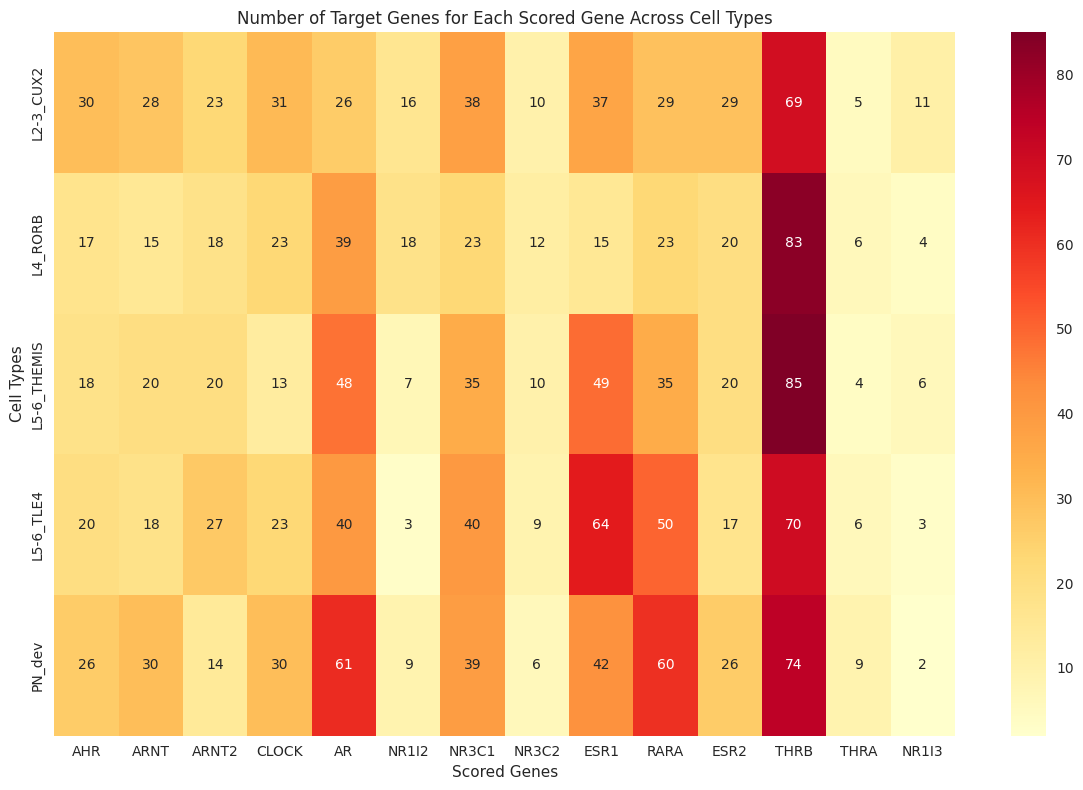

In [43]:
create_heatmap(gene_sets_dict_cell_type_first_celloracle, set_selected, scored_genes, cell_types)

### Venn diagrams


Shared genes between the sets:
Shared between RARA & THRB: {'H1FX', 'MLIP', 'CDH18'}
Shared between RARA & AR: {'MICAL2'}
Shared between THRB & AR: {'SNTG1', 'EPHA6', 'RASGRF2', 'CNTN5'}


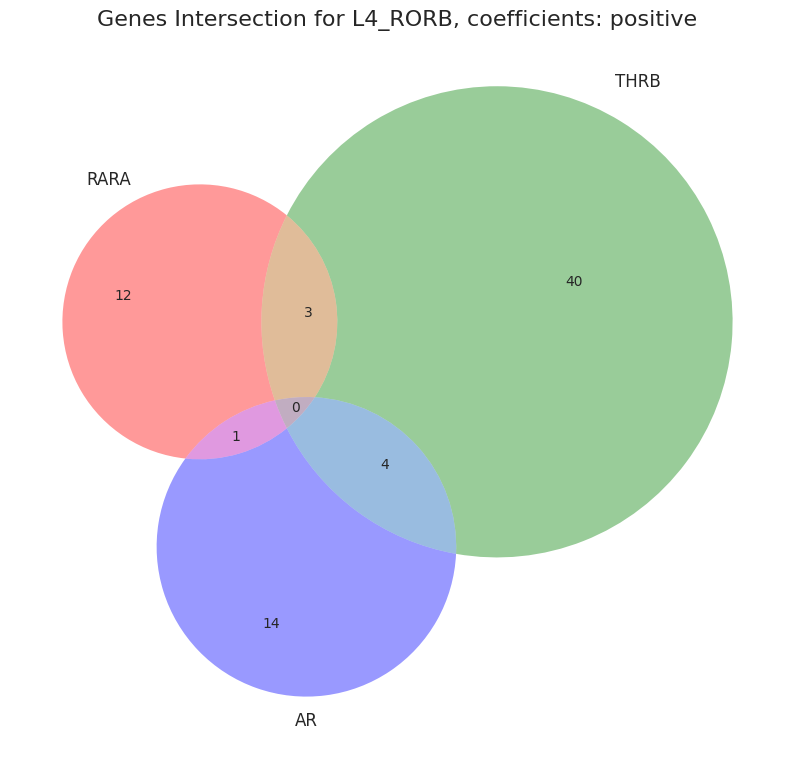

In [44]:
scored_genes=["RARA", "THRB", "AR"]
cell_type = "L4_RORB"
analyze_gene_sets_gene_set(gene_sets_dict_cell_type_first_celloracle, set_selected, cell_type=cell_type, scored_genes=scored_genes, mode="positive", printouts=True)

Gene PAM not found in the dataset.
Gene OXR1 not found in the dataset.
Gene RBFOX1 not found in the dataset.
Gene CPVL not found in the dataset.


/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


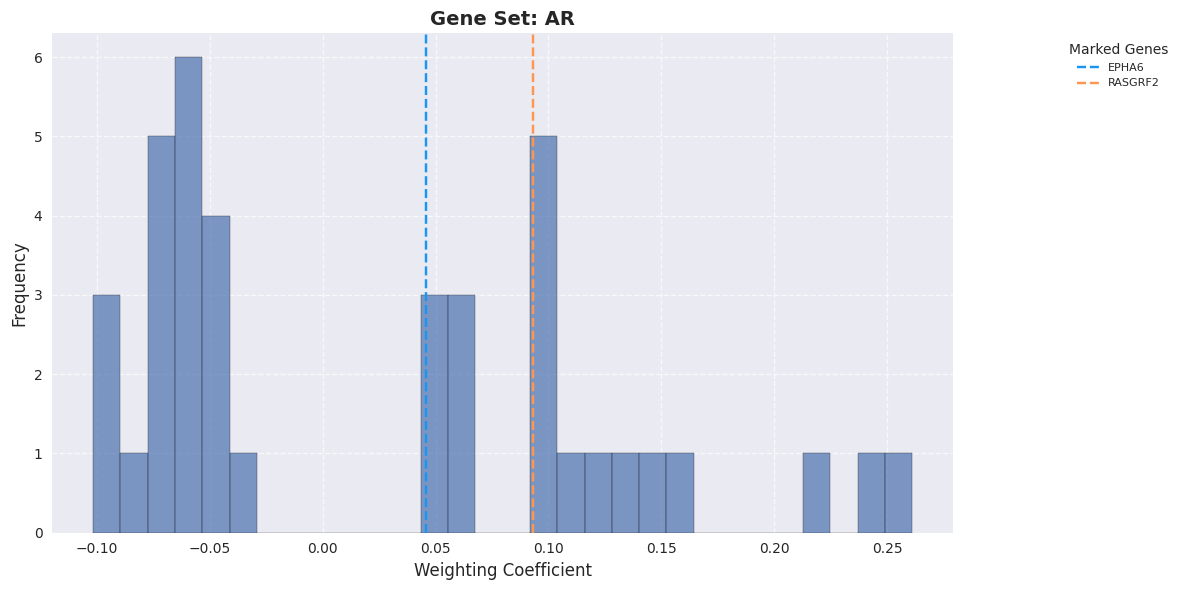

In [45]:
genes_to_mark = ['PAM', 'EPHA6', 'OXR1', 'RBFOX1', 'RASGRF2', 'CPVL']
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, "L4_RORB", "AR", score="coef_mean", bins=30, genes_to_mark=genes_to_mark)

Gene BDNF not found in the dataset.
Gene PRKG2 not found in the dataset.
Gene UBB not found in the dataset.


/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


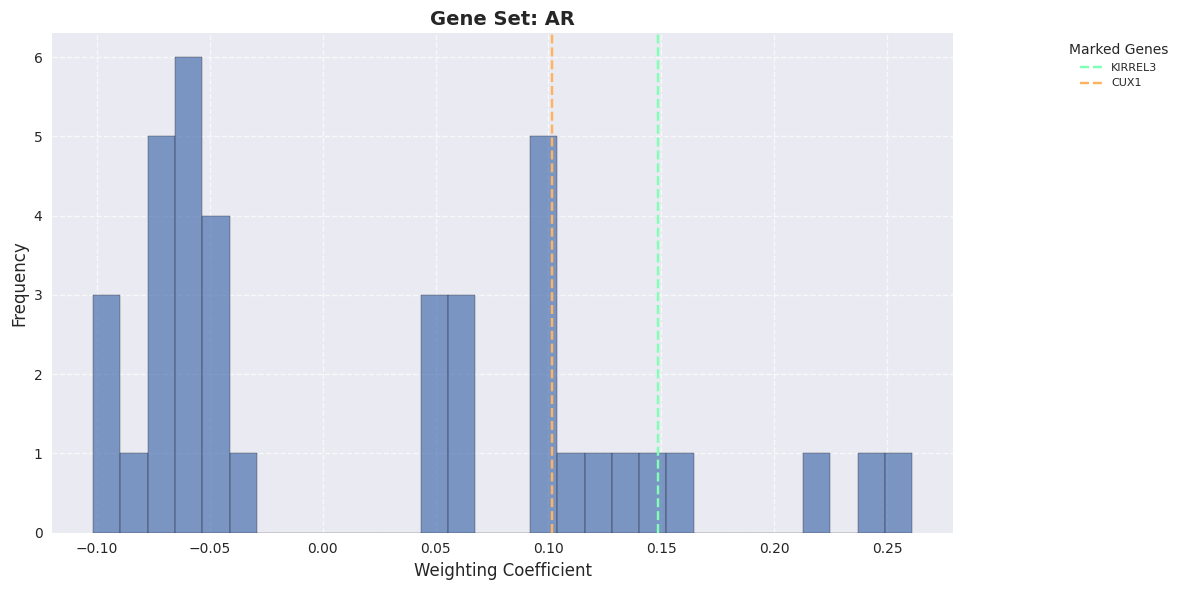

In [46]:
genes_to_mark = ['BDNF', 'PRKG2', 'KIRREL3', 'CUX1', 'UBB']
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, "L4_RORB", "AR", score="coef_mean", bins=30, genes_to_mark=genes_to_mark)

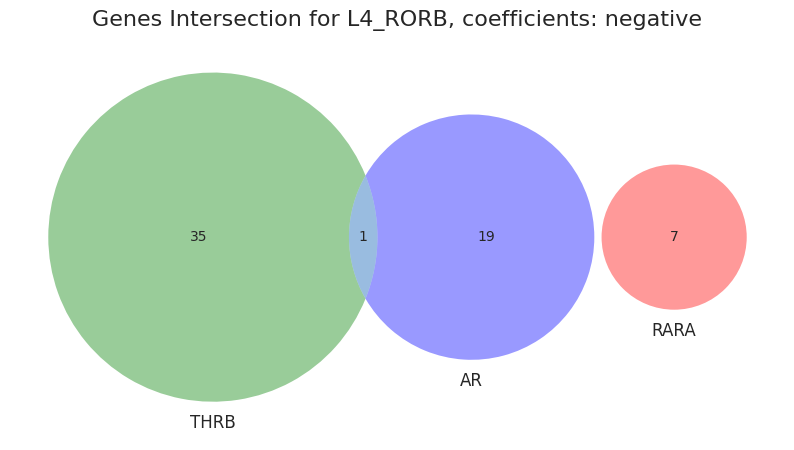

In [47]:
scored_genes=["RARA", "THRB", "AR"]
cell_type = "L4_RORB"
analyze_gene_sets_gene_set(gene_sets_dict_cell_type_first_celloracle, set_selected, cell_type=cell_type, scored_genes=scored_genes, mode="negative")


Unique genes for each set:
L2-3_CUX2: {'PHYHIPL', 'RASGRF2', 'LINC-PINT'}
L4_RORB: {'ELMO1', 'PTPRZ1'}
L5-6_THEMIS: set()


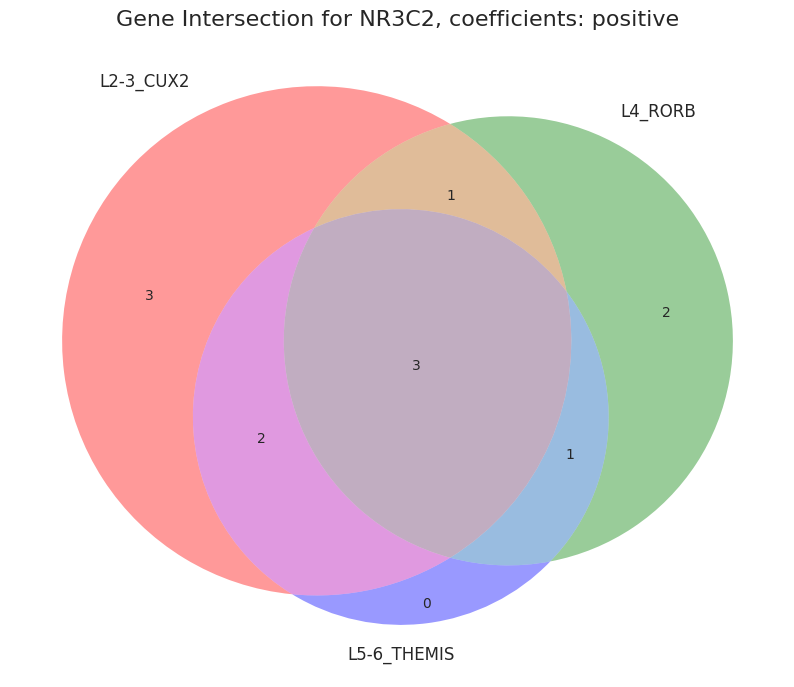

In [48]:
cell_types=["L2-3_CUX2", "L4_RORB", "L5-6_THEMIS"]
scored_gene="NR3C2"

analyze_gene_sets_cell_types(gene_sets_dict_cell_type_first_celloracle, set_selected, scored_gene, cell_types, mode = "positive", printouts=True)

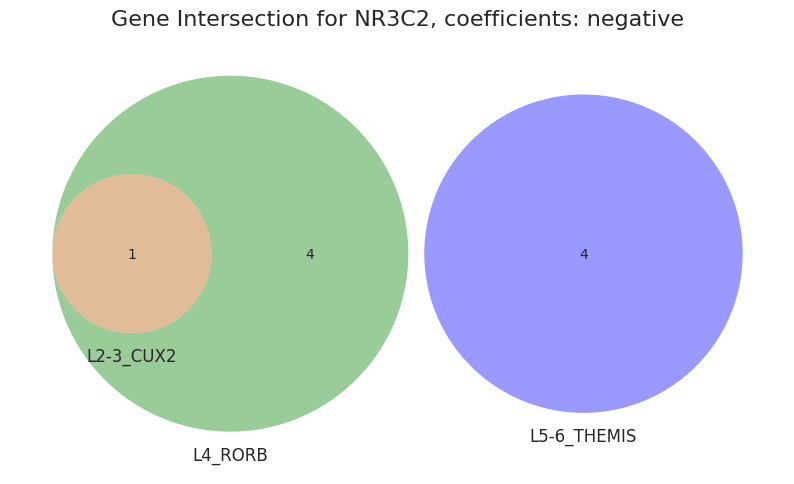

In [49]:
cell_types=["L2-3_CUX2", "L4_RORB", "L5-6_THEMIS"]
scored_gene="NR3C2"

analyze_gene_sets_cell_types(gene_sets_dict_cell_type_first_celloracle, set_selected, scored_gene, cell_types, mode = "negative")

### Histograms

/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


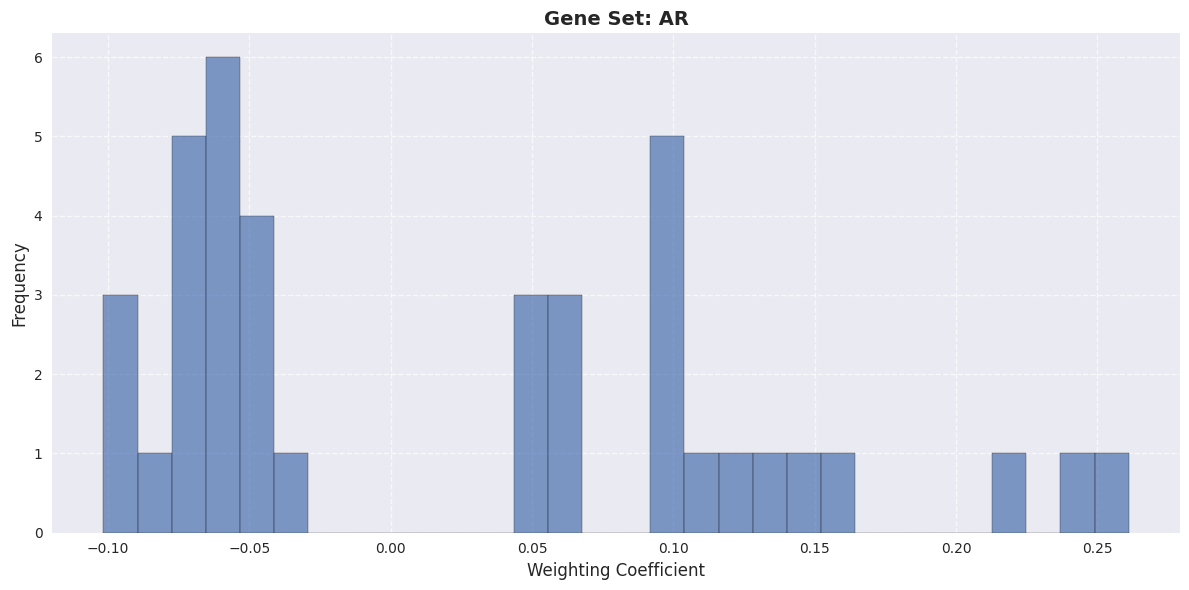

In [50]:
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, cell_type_selected, "AR", score="coef_mean", bins=30)

/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


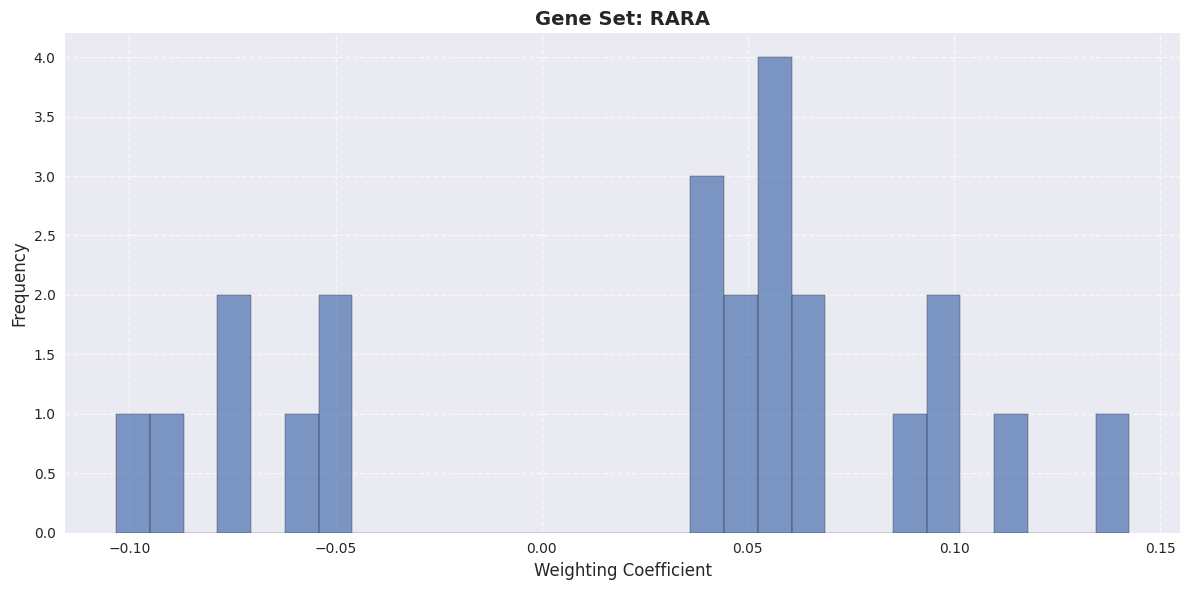

In [51]:
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, cell_type_selected, scored_gene_selected, score="coef_mean", bins=30)

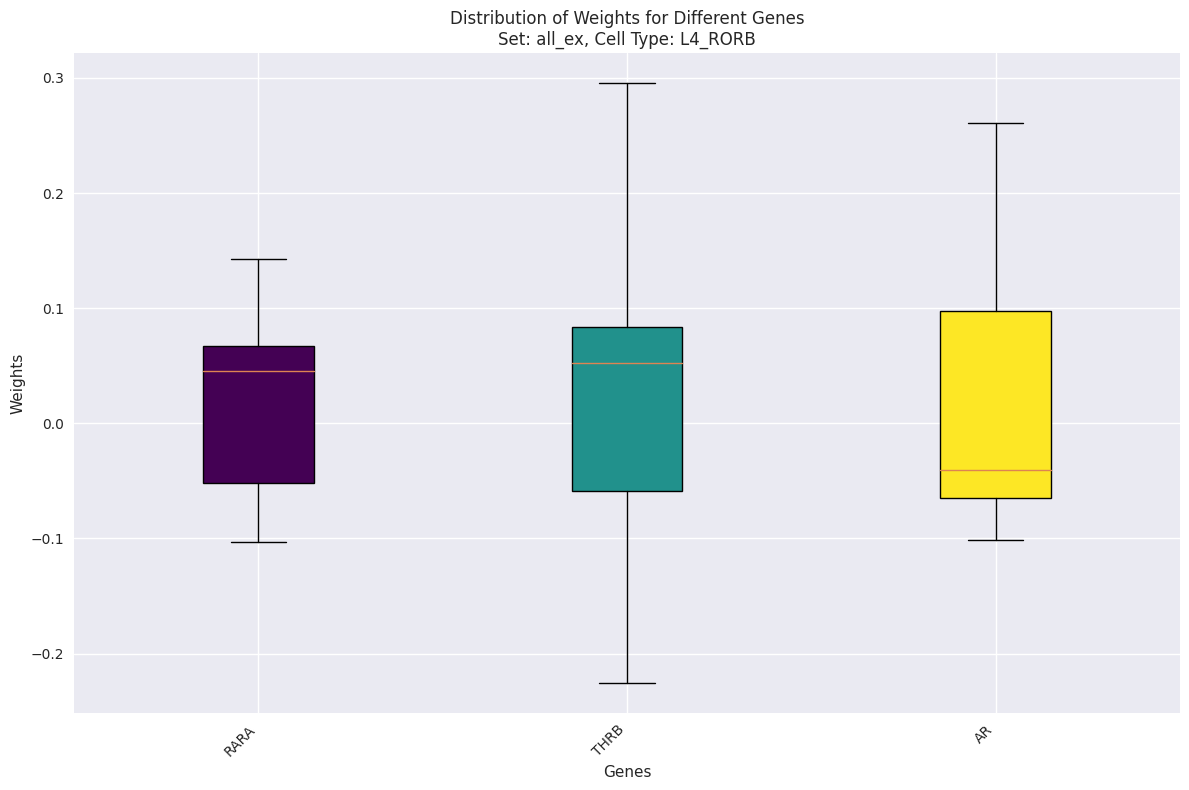

In [53]:
visualize_weight_distributions(gene_sets_dict_cell_type_first_celloracle, set_selected, cell_type_selected, scored_genes, score_type="coef_mean")

### Intersections

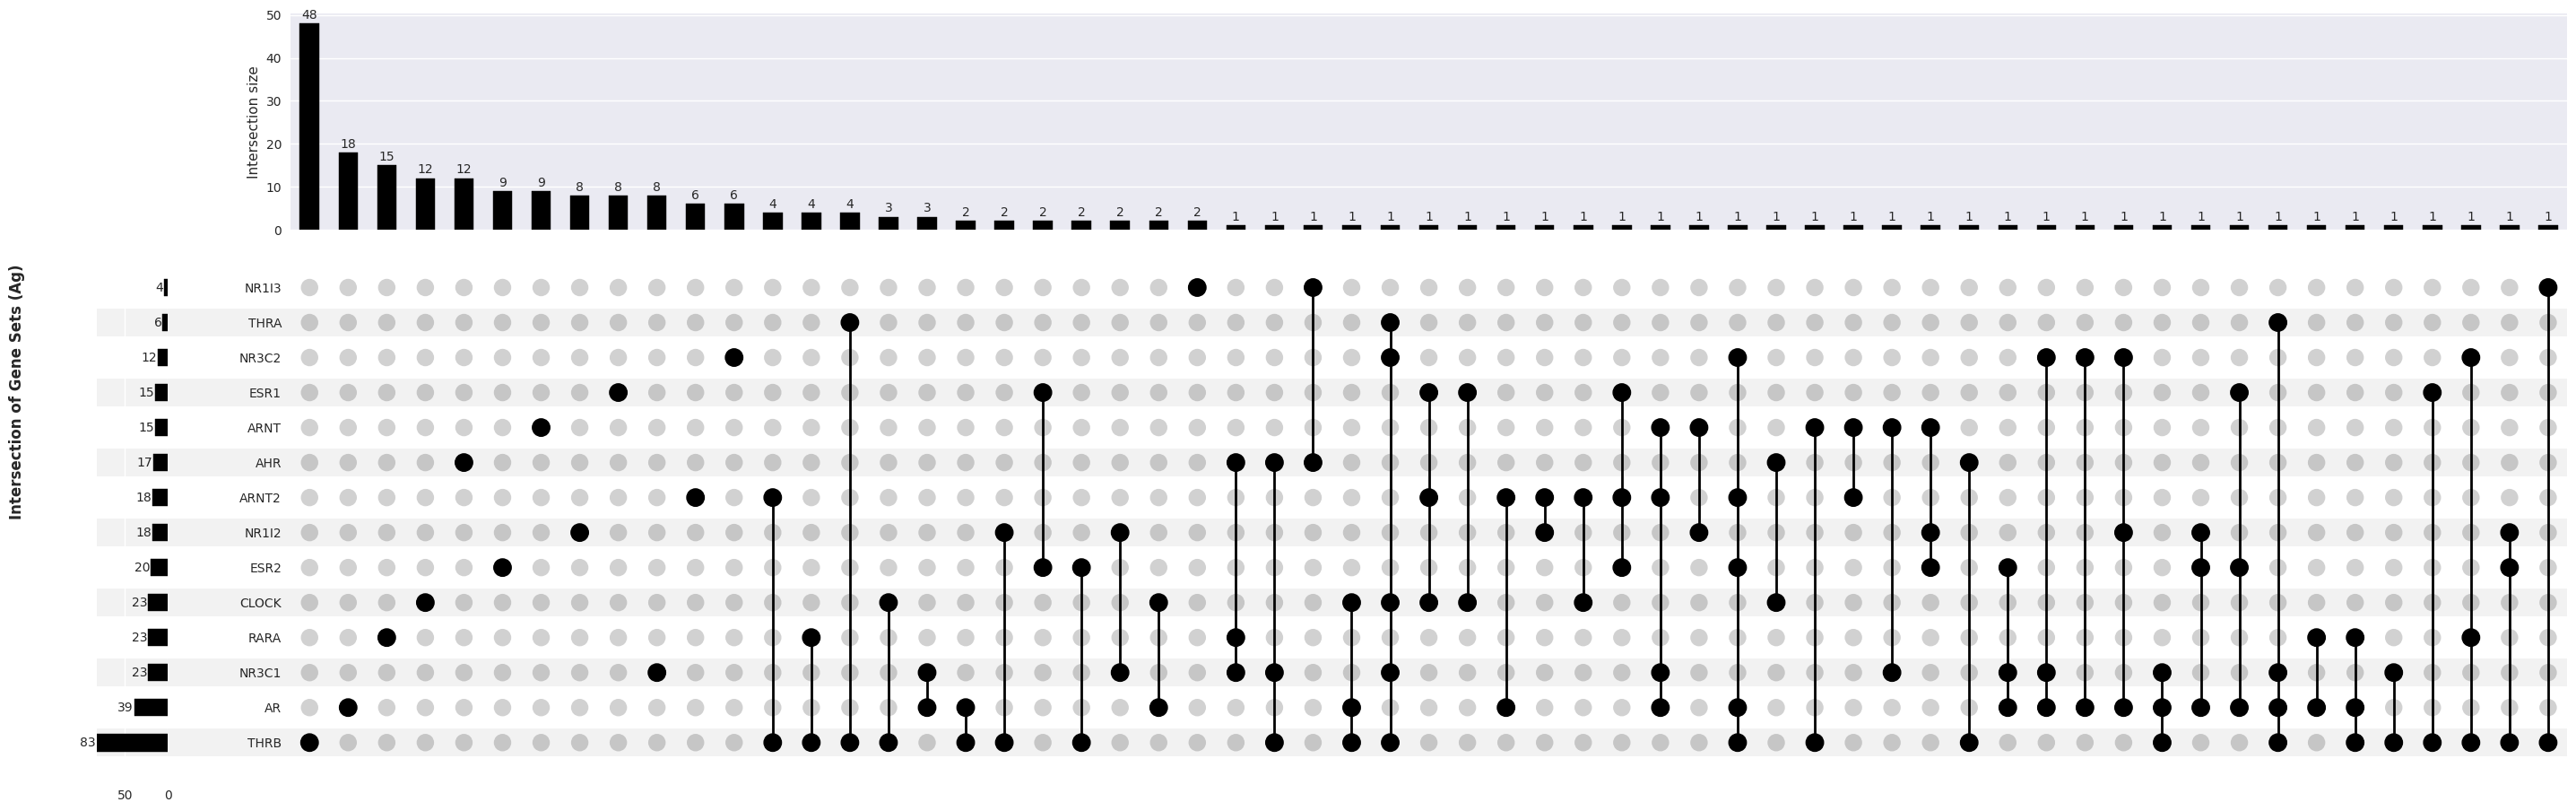

In [54]:
data={key: gene_sets_dict_cell_type_first_celloracle[set_selected][cell_type_selected][key]["targets"] for key in gois}

helpers_internal_data.plot_gene_set_intersections(data, title="Intersection of Gene Sets (Ag)")

### Histograms of the unique genes

Unique genes for each set:

L2-3_CUX2: {'SASH1', 'HTR1B', 'MICAL2', 'BCL9', 'RASGRF2'}

L4_RORB: {'GFRA1', 'RGS6', 'ATF5', 'GDF5', 'NCAM2', 'SESN3', 'FN1', 'KIF26B', 'NR4A3', 'PTPRZ1', 'TUBB2B', 'SOX5', 'BHLHE22', 'LINGO2'}

L5-6_THEMIS: {'HIST1H1E', 'COMMD3-BMI1', 'ETV5', 'TXNIP', 'CH25H', 'USP39', 'RARB', 'HIST1H2BN', 'LPL'}

Gene SASH1 not found in the dataset.
Gene HTR1B not found in the dataset.
Gene MICAL2 not found in the dataset.
Gene BCL9 not found in the dataset.


/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


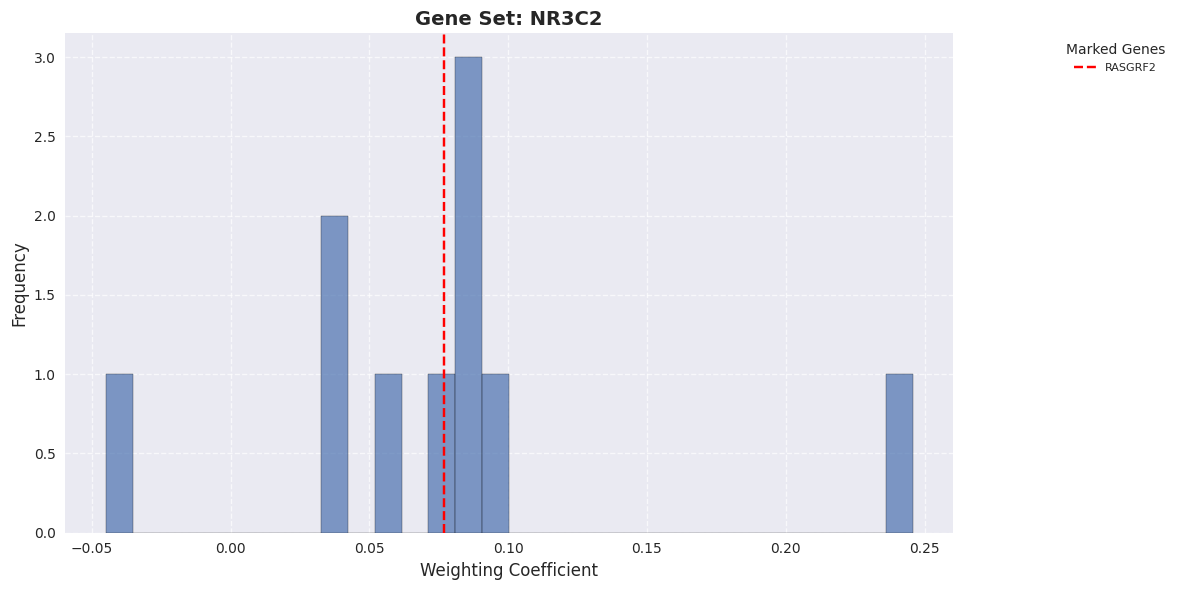

In [55]:
genes_to_mark = ['SASH1', 'HTR1B', 'MICAL2', 'BCL9', 'RASGRF2']
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, "L2-3_CUX2", "NR3C2", score="coef_mean", bins=30, genes_to_mark=genes_to_mark)

/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Gene GFRA1 not found in the dataset.
Gene RGS6 not found in the dataset.
Gene ATF5 not found in the dataset.
Gene GDF5 not found in the dataset.
Gene NCAM2 not found in the dataset.
Gene SESN3 not found in the dataset.
Gene FN1 not found in the dataset.
Gene KIF26B not found in the dataset.
Gene NR4A3 not found in the dataset.
Gene TUBB2B not found in the dataset.
Gene SOX5 not found in the dataset.
Gene BHLHE22 not found in the dataset.


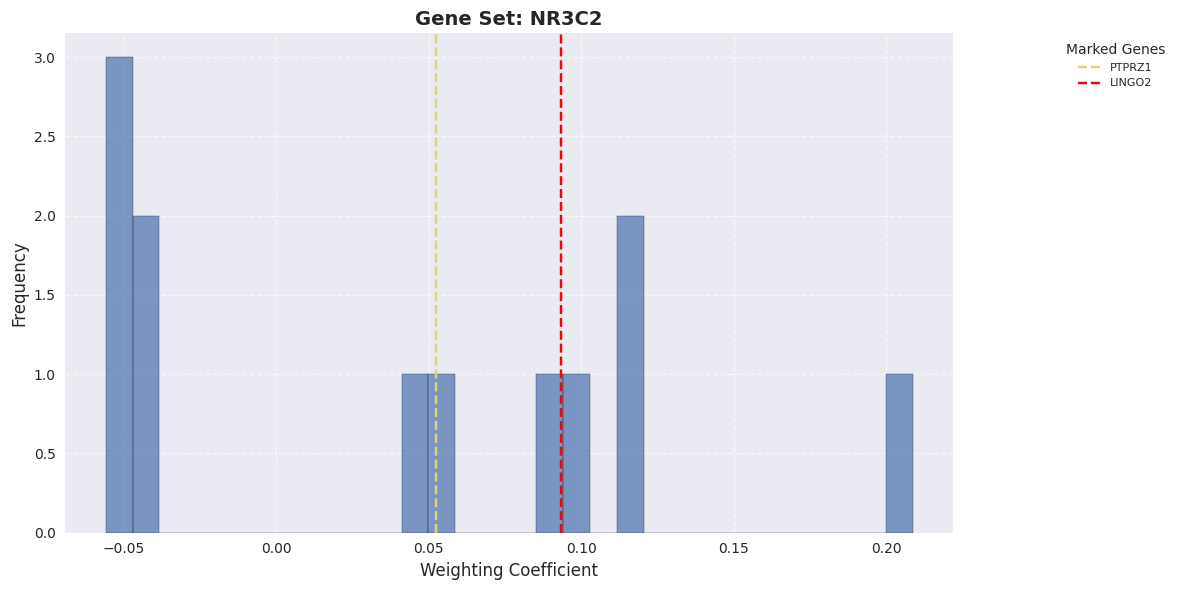

In [56]:
genes_to_mark = ['GFRA1', 'RGS6', 'ATF5', 'GDF5', 'NCAM2', 'SESN3', 'FN1', 'KIF26B', 'NR4A3', 'PTPRZ1', 'TUBB2B', 'SOX5', 'BHLHE22', 'LINGO2']
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, "L4_RORB", "NR3C2", score="coef_mean", bins=30, genes_to_mark=genes_to_mark)

/localscratch/18111745.michal.kubacki/ipykernel_218311/2985293363.py:169: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Gene HIST1H1E not found in the dataset.
Gene COMMD3-BMI1 not found in the dataset.
Gene ETV5 not found in the dataset.
Gene TXNIP not found in the dataset.
Gene CH25H not found in the dataset.
Gene USP39 not found in the dataset.
Gene RARB not found in the dataset.
Gene HIST1H2BN not found in the dataset.
Gene LPL not found in the dataset.


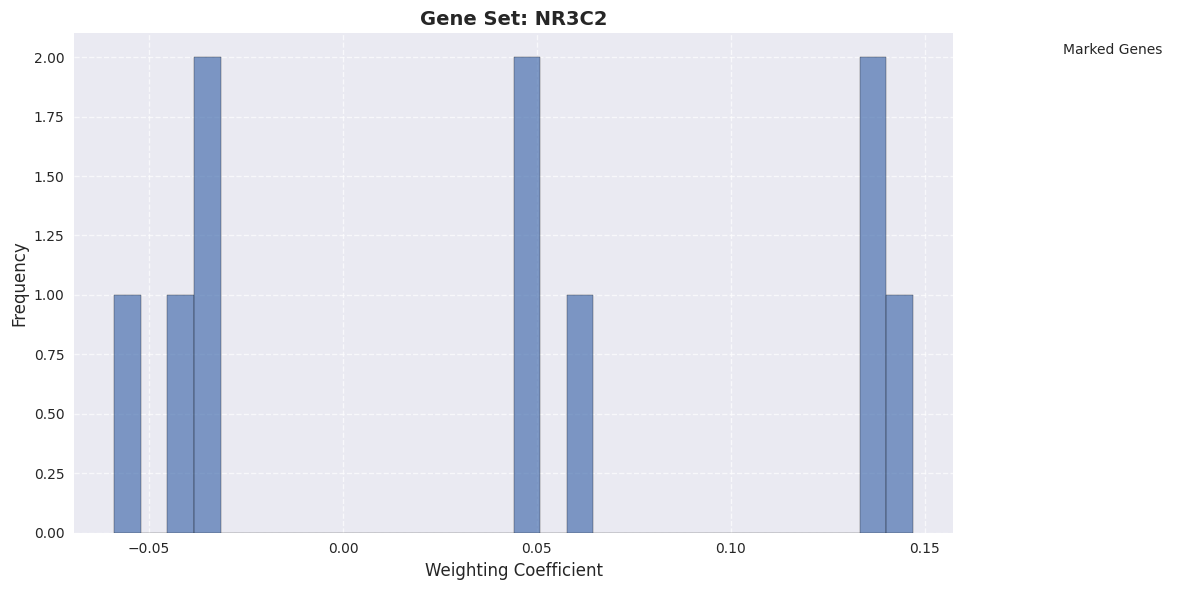

In [57]:
genes_to_mark = ['HIST1H1E', 'COMMD3-BMI1', 'ETV5', 'TXNIP', 'CH25H', 'USP39', 'RARB', 'HIST1H2BN', 'LPL']
better_hist_GRNs(gene_sets_dict_cell_type_first_celloracle, set_selected, "L5-6_THEMIS", "NR3C2", score="coef_mean", bins=30, genes_to_mark=genes_to_mark)